In [1]:
#####################
# Train & Eval
#####################

# coding=utf-8
# Copyright 2021 The Google Research Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Lint as: python3
"""Trains TFT based on a defined set of parameters.
Uses default parameters supplied from the configs file to train a TFT model from
scratch.

Usage:
python3 script_train_fixed_params {expt_name} {output_folder}

Command line args:
  expt_name: Name of dataset/experiment to train.
  output_folder: Root folder in which experiment is saved
"""

import argparse
import datetime as dte
import os,sys
sys.path.append('/tf/crypto_prediction_ml_dl/script')
sys.path.append('/tf/crypto_prediction_ml_dl/notebook/TFT_models')

import data_formatters.base
import expt_settings.configs
import libs.hyperparam_opt
import libs.tft_custom_model
import libs.utils as utils
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf


import tensorflow
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))


ExperimentConfig = expt_settings.configs.ExperimentConfig
HyperparamOptManager = libs.hyperparam_opt.HyperparamOptManager
ModelClass = libs.tft_custom_model.TemporalFusionTransformer
tf.experimental.output_all_intermediates(True)

2023-11-21 12:19:38.652114: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-21 12:19:38.770679: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  1


2023-11-21 12:19:40.472024: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-21 12:19:40.483726: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-21 12:19:40.483856: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
def main_train(expt_name,
         use_gpu,
         model_folder,
         data_csv_path,
         data_formatter,
         use_testing_mode=False):
    """Trains tft based on defined model params.

    Args:
      expt_name: Name of experiment
      use_gpu: Whether to run tensorflow with GPU operations
      model_folder: Folder path where models are serialized
      data_csv_path: Path to csv file containing data
      data_formatter: Dataset-specific data fromatter (see
        expt_settings.dataformatter.GenericDataFormatter)
      use_testing_mode: Uses a smaller models and data sizes for testing purposes
        only -- switch to False to use original default settings
    """

    num_repeats = 1

    if not isinstance(data_formatter, data_formatters.base.GenericDataFormatter):
        raise ValueError(
            "Data formatters should inherit from" +
            "AbstractDataFormatter! Type={}".format(type(data_formatter)))

    # Tensorflow setup
    default_keras_session = tf.keras.backend.get_session()

    if use_gpu:
        tf_config = utils.get_default_tensorflow_config(tf_device="gpu", gpu_id=0)

    else:
        tf_config = utils.get_default_tensorflow_config(tf_device="cpu")

    print("*** Training from defined parameters for {} ***".format(expt_name))

    print("Loading & splitting data...")
    raw_data = pd.read_csv(data_csv_path, index_col=0)
    train, valid, test = data_formatter.split_data(raw_data)
    train_samples, valid_samples = data_formatter.get_num_samples_for_calibration()

    # Sets up default params
    fixed_params = data_formatter.get_experiment_params()
    params = data_formatter.get_default_model_params()
    params["model_folder"] = model_folder

    # Parameter overrides for testing only! Small sizes used to speed up script.
    if use_testing_mode:
        fixed_params["num_epochs"] = 1
        params["hidden_layer_size"] = 5
        train_samples, valid_samples = 100, 10

    # Sets up hyperparam manager
    print("*** Loading hyperparm manager ***")
    opt_manager = HyperparamOptManager({k: [params[k]] for k in params},
                                       fixed_params, model_folder)


    # Training -- one iteration only
    print("*** Running calibration ***")
    print("Params Selected:")
    for k in params:
        print("{}: {}".format(k, params[k]))

    best_loss = np.Inf
    for _ in range(num_repeats):

        tf.reset_default_graph()
        with tf.Graph().as_default(), tf.Session(config=tf_config) as sess:

            tf.keras.backend.set_session(sess)

            params = opt_manager.get_next_parameters()
            model = ModelClass(params, use_cudnn=use_gpu)

            if not model.training_data_cached():
                model.cache_batched_data(train, "train", num_samples=train_samples)
                model.cache_batched_data(valid, "valid", num_samples=valid_samples)

            sess.run(tf.global_variables_initializer())
            model.fit()

            val_loss = model.evaluate()

            if val_loss < best_loss:
                opt_manager.update_score(params, val_loss, model)
                best_loss = val_loss

            tf.keras.backend.set_session(default_keras_session)

    print("*** Running tests ***")
    tf.reset_default_graph()
    with tf.Graph().as_default(), tf.Session(config=tf_config) as sess:
        tf.keras.backend.set_session(sess)
        
        best_params = opt_manager.get_best_params()
        
        model = ModelClass(best_params, use_cudnn=use_gpu)

        model.load(opt_manager.hyperparam_folder)

        print("Computing best validation loss")
        val_loss = model.evaluate(valid)

        print("Computing test loss")
        output_map = model.predict_with_custom_loss(test, return_targets=True)

        targets = output_map["targets"]
        results = output_map["results"]

        tf.keras.backend.set_session(default_keras_session)

    print("Training completed @ {}".format(dte.datetime.now()))
    print("Best validation loss = {}".format(val_loss))
    print("Params:")

    for k in best_params:
        print(k, " = ", best_params[k])
    
    return output_map

In [3]:
dataset_name = 'crypto_day_all'
output_folder = '.'
use_tensorflow_with_gpu = 'yes'

print("Using output folder {}".format(output_folder))

config = ExperimentConfig(dataset_name, output_folder)
formatter = config.make_data_formatter()


# Customise inputs to main() for new datasets.
output_map = main_train(
    expt_name=dataset_name,
    use_gpu=use_tensorflow_with_gpu,
    model_folder=os.path.join(config.model_folder, "fixed"),
    data_csv_path=config.data_csv_path,
    data_formatter=formatter,
    use_testing_mode=False)  # Change to false to use original default params

2023-11-21 12:19:40.536337: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-21 12:19:40.536469: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-21 12:19:40.536566: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Using output folder .


2023-11-21 12:19:41.025142: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-21 12:19:41.025293: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-21 12:19:41.025403: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Selecting GPU ID=0
*** Training from defined parameters for crypto_day_all ***
Loading & splitting data...
Formatting train-valid-test splits.
Setting scalers with training data...
*** Loading hyperparm manager ***
*** Running calibration ***
Params Selected:
dropout_rate: 0.3
hidden_layer_size: 20
learning_rate: 0.001
minibatch_size: 64
max_gradient_norm: 1.0
num_heads: 1
stack_size: 1
model_folder: ./saved_models/crypto_day_all/fixed
Resetting temp folder...
*** TemporalFusionTransformer params ***
# dropout_rate = 0.3
# hidden_layer_size = 20
# learning_rate = 0.001
# max_gradient_norm = 1.0
# minibatch_size = 64
# model_folder = ./saved_models/crypto_day_all/fixed
# num_heads = 1
# stack_size = 1
# total_time_steps = 31
# num_encoder_steps = 30
# num_epochs = 100
# early_stopping_patience = 10
# multiprocessing_workers = 10
# column_definition = [('btc_id', <DataTypes.CATEGORICAL: 1>, <InputTypes.ID: 4>), ('btc_dt', <DataTypes.DATE: 2>, <InputTypes.TIME: 5>), ('btc_row_id', <DataTy

2023-11-21 12:19:41.249198: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_2/stack_1' id:12 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_2/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [3] values: 0 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-21 12:19:41.251329: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_2/stack_2' id:13 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_2/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [3] values: 1 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutation 

2023-11-21 12:19:41.455807: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_12/stack_1' id:398 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_12/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 0 11>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-21 12:19:41.459590: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_12/stack_2' id:399 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_12/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutati

2023-11-21 12:19:41.661488: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_19/stack_2' id:672 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_19/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-21 12:19:41.680184: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_16/kernel/Assign' id:692 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_16/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_16/kernel, TemporalFusionTransformer/

2023-11-21 12:19:41.865929: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_21/kernel/Assign' id:887 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_21/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_21/kernel, TemporalFusionTransformer/time_distributed_21/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-21 12:19:41.876509: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_25/stack_1' id:905 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_25/stack_1}} = Const[_has_manual_control_dependencies=true, dty

2023-11-21 12:19:42.077909: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_26/bias/Assign' id:1087 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_26/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_26/bias, TemporalFusionTransformer/time_distributed_26/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-21 12:19:42.090400: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_30/stack_1' id:1100 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_30/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor

2023-11-21 12:19:42.591870: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/dense_50/kernel/Assign' id:2043 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/dense_50/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/dense_50/kernel, TemporalFusionTransformer/dense_50/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-21 12:19:42.635737: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/concat/axis' id:1230 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/concat/axis}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [] values: 3>]()}}' was

2023-11-21 12:19:43.028121: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_38/stack_1' id:2560 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_38/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 0 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-21 12:19:43.052621: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_38/stack_2' id:2561 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_38/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutat

2023-11-21 12:19:44.058038: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_57/kernel/Assign' id:3583 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_57/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_57/kernel, TemporalFusionTransformer/time_distributed_57/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-21 12:19:44.109910: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_44/stack_1' id:3717 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_44/stack_1}} = Const[_has_manual_control_dependencies=true, d

2023-11-21 12:19:45.217994: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_79/bias/Assign' id:4620 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_79/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_79/bias, TemporalFusionTransformer/time_distributed_79/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-21 12:19:45.284591: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_49/stack_1' id:4682 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_49/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor

2023-11-21 12:19:46.776957: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_99/kernel/Assign' id:5580 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_99/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_99/kernel, TemporalFusionTransformer/time_distributed_99/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-21 12:19:46.861204: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_54/stack_1' id:5647 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_54/stack_1}} = Const[_has_manual_control_dependencies=true, d

2023-11-21 12:19:48.504066: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/layer_normalization_27/beta/Assign' id:6573 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/layer_normalization_27/beta/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/layer_normalization_27/beta, TemporalFusionTransformer/layer_normalization_27/beta/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-21 12:19:48.607427: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_59/stack_1' id:6612 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_59/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, 

2023-11-21 12:19:50.311672: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_63/stack_2' id:7385 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_63/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-21 12:19:50.536194: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/layer_normalization_32/beta/Assign' id:7538 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/layer_normalization_32/beta/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/layer_normalization_32/beta, TemporalFusionTransfo

2023-11-21 12:19:52.403729: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/layer_normalization_36/gamma/Assign' id:8305 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/layer_normalization_36/gamma/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/layer_normalization_36/gamma, TemporalFusionTransformer/layer_normalization_36/gamma/Initializer/ones)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-21 12:19:52.647700: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_36/stack' id:1232 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_36/stack}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, v

2023-11-21 12:19:54.603365: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/cu_dnnlstm_1/bias/Assign' id:9029 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/cu_dnnlstm_1/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/cu_dnnlstm_1/bias, TemporalFusionTransformer/cu_dnnlstm_1/bias/Initializer/concat)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-21 12:19:54.771491: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/concat_3/axis' id:9140 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/concat_3/axis}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [] values: 1>]()}}' was chang

2023-11-21 12:19:56.870583: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_69/stack' id:9476 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_69/stack}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [1] values: 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-21 12:19:56.994386: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_69/stack_1' id:9477 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_69/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [1] values: 2>]()}}' was changed by setting attribute after it was run by a session. This mutation will

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 31, 31)]             0         []                            
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 31, 31)]             0         ['input_1[0][0]']             
 Transformer/strided_slice                                                                        
 (TensorFlowOpLayer)                                                                              
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 1)]                  0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/strided_slice[0]

 Transformer/concat_1/conca                                         ]                             
 t (TensorFlowOpLayer)                                                                            
                                                                                                  
 multiply_2 (Multiply)       (None, 1, 20)                0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/ExpandDims[0][0]',  
                                                                     'tf_op_layer_TemporalFusionTr
                                                                    ansformer/concat_1/concat[0][0
                                                                    ]']                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 20)]                 0         ['multiply_2[0][0]']          
 Transform

                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 31, 1)]              0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/strided_slice[0][0]'
 20 (TensorFlowOpLayer)                                             ]                             
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 31, 1)]              0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/strided_slice[0][0]'
 21 (TensorFlowOpLayer)                                             ]                             
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 31, 1)]              0         ['tf_op_layer_TemporalFusionTr
 Transform

2023-11-21 12:19:57.803217: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_75/stack_2' id:10120 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_75/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [3] values: 1 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


 3 (TensorFlowOpLayer)                                              ]                             
                                                                                                  
 dropout_2 (Dropout)         (None, 20)                   0         ['dense_41[0][0]']            
                                                                                                  
 time_distributed_1 (TimeDi  (None, 31, 20)               40        ['tf_op_layer_TemporalFusionTr
 stributed)                                                         ansformer/strided_slice_4[0][0
                                                                    ]']                           
                                                                                                  
 time_distributed_2 (TimeDi  (None, 31, 20)               40        ['tf_op_layer_TemporalFusionTr
 stributed)                                                         ansformer/strided_slice_5[0][0
          

                                                                                                  
 time_distributed_21 (TimeD  (None, 31, 20)               40        ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/strided_slice_24[0][
                                                                    0]']                          
                                                                                                  
 time_distributed_22 (TimeD  (None, 31, 20)               40        ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/strided_slice_25[0][
                                                                    0]']                          
                                                                                                  
 time_distributed_23 (TimeD  (None, 31, 20)               40        ['tf_op_layer_TemporalFusionTr
 istribute

                                                                     'dense_43[0][0]']            
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 30, 20, 28)]         0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/stack_2[0][0]']     
 33 (TensorFlowOpLayer)                                                                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 30, 20, 1)]          0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/stack_3[0][0]']     
 34 (TensorFlowOpLayer)                                                                           
                                                                                                  
 tf_op_lay

 43 (TensorFlowOpLayer)                                                                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 30, 20)]             0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/concat[0][0]']      
 44 (TensorFlowOpLayer)                                                                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 30, 20)]             0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/concat[0][0]']      
 45 (TensorFlowOpLayer)                                                                           
                                                                                                  
 tf_op_lay

 Transformer/strided_slice_                                         ansformer/concat[0][0]']      
 64 (TensorFlowOpLayer)                                                                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 30, 20)]             0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/concat[0][0]']      
 65 (TensorFlowOpLayer)                                                                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 30, 20)]             0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/concat[0][0]']      
 66 (TensorFlowOpLayer)                                                                           
          

                                                                                                  
 time_distributed_96 (TimeD  (None, 30, 20)               420       ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/strided_slice_53[0][
                                                                    0]']                          
                                                                                                  
 time_distributed_100 (Time  (None, 30, 20)               420       ['tf_op_layer_TemporalFusionTr
 Distributed)                                                       ansformer/strided_slice_54[0][
                                                                    0]']                          
                                                                                                  
 time_distributed_104 (Time  (None, 30, 20)               420       ['tf_op_layer_TemporalFusionTr
 Distribut

                                                                                                  
 activation_15 (Activation)  (None, 30, 20)               0         ['time_distributed_60[0][0]'] 
                                                                                                  
 activation_16 (Activation)  (None, 30, 20)               0         ['time_distributed_64[0][0]'] 
                                                                                                  
 activation_17 (Activation)  (None, 30, 20)               0         ['time_distributed_68[0][0]'] 
                                                                                                  
 activation_18 (Activation)  (None, 30, 20)               0         ['time_distributed_72[0][0]'] 
                                                                                                  
 activation_19 (Activation)  (None, 30, 20)               0         ['time_distributed_76[0][0]'] 
          

 istributed)                                                                                      
                                                                                                  
 time_distributed_73 (TimeD  (None, 30, 20)               420       ['activation_18[0][0]']       
 istributed)                                                                                      
                                                                                                  
 time_distributed_77 (TimeD  (None, 30, 20)               420       ['activation_19[0][0]']       
 istributed)                                                                                      
                                                                                                  
 time_distributed_81 (TimeD  (None, 30, 20)               420       ['activation_20[0][0]']       
 istributed)                                                                                      
          

                                                                                                  
 dropout_11 (Dropout)        (None, 30, 20)               0         ['time_distributed_53[0][0]'] 
                                                                                                  
 dropout_12 (Dropout)        (None, 30, 20)               0         ['time_distributed_57[0][0]'] 
                                                                                                  
 dropout_13 (Dropout)        (None, 30, 20)               0         ['time_distributed_61[0][0]'] 
                                                                                                  
 dropout_14 (Dropout)        (None, 30, 20)               0         ['time_distributed_65[0][0]'] 
                                                                                                  
 dropout_15 (Dropout)        (None, 30, 20)               0         ['time_distributed_69[0][0]'] 
          

 istributed)                                                                                      
                                                                                                  
 time_distributed_47 (TimeD  (None, 30, 20)               420       ['dropout_9[0][0]']           
 istributed)                                                                                      
                                                                                                  
 time_distributed_50 (TimeD  (None, 30, 20)               420       ['dropout_10[0][0]']          
 istributed)                                                                                      
                                                                                                  
 time_distributed_51 (TimeD  (None, 30, 20)               420       ['dropout_10[0][0]']          
 istributed)                                                                                      
          

 time_distributed_102 (Time  (None, 30, 20)               420       ['dropout_23[0][0]']          
 Distributed)                                                                                     
                                                                                                  
 time_distributed_103 (Time  (None, 30, 20)               420       ['dropout_23[0][0]']          
 Distributed)                                                                                     
                                                                                                  
 time_distributed_106 (Time  (None, 30, 20)               420       ['dropout_24[0][0]']          
 Distributed)                                                                                     
                                                                                                  
 time_distributed_107 (Time  (None, 30, 20)               420       ['dropout_24[0][0]']          
 Distribut

                                                                                                  
 activation_5 (Activation)   (None, 20)                   0         ['dense_48[0][0]']            
                                                                                                  
 activation_6 (Activation)   (None, 20)                   0         ['dense_52[0][0]']            
                                                                                                  
 time_distributed_160 (Time  (None, 1, 1)                 21        ['dropout_37[0][0]']          
 Distributed)                                                                                     
                                                                                                  
 time_distributed_161 (Time  (None, 1, 1)                 21        ['dropout_37[0][0]']          
 Distributed)                                                                                     
          

                                                                     'time_distributed_127[0][0]']
                                                                                                  
 multiply_31 (Multiply)      (None, 30, 20)               0         ['time_distributed_130[0][0]',
                                                                     'time_distributed_131[0][0]']
                                                                                                  
 multiply_32 (Multiply)      (None, 30, 20)               0         ['time_distributed_134[0][0]',
                                                                     'time_distributed_135[0][0]']
                                                                                                  
 multiply_33 (Multiply)      (None, 30, 20)               0         ['time_distributed_138[0][0]',
                                                                     'time_distributed_139[0][0]']
          

                                                                    ansformer/strided_slice_46[0][
                                                                    0]',                          
                                                                     'multiply_16[0][0]']         
                                                                                                  
 add_16 (Add)                (None, 30, 20)               0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/strided_slice_47[0][
                                                                    0]',                          
                                                                     'multiply_17[0][0]']         
                                                                                                  
 add_17 (Add)                (None, 30, 20)               0         ['tf_op_layer_TemporalFusionTr
          

                                                                                                  
 add_32 (Add)                (None, 30, 20)               0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/strided_slice_63[0][
                                                                    0]',                          
                                                                     'multiply_33[0][0]']         
                                                                                                  
 add_33 (Add)                (None, 30, 20)               0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/strided_slice_64[0][
                                                                    0]',                          
                                                                     'multiply_34[0][0]']         
          

                                                                                                  
 layer_normalization_22 (La  (None, 30, 20)               40        ['add_22[0][0]']              
 yerNormalization)                                                                                
                                                                                                  
 layer_normalization_23 (La  (None, 30, 20)               40        ['add_23[0][0]']              
 yerNormalization)                                                                                
                                                                                                  
 layer_normalization_24 (La  (None, 30, 20)               40        ['add_24[0][0]']              
 yerNormalization)                                                                                
                                                                                                  
 layer_nor

                                                                    ',                            
                                                                     'layer_normalization_17[0][0]
                                                                    ',                            
                                                                     'layer_normalization_18[0][0]
                                                                    ',                            
                                                                     'layer_normalization_19[0][0]
                                                                    ',                            
                                                                     'layer_normalization_20[0][0]
                                                                    ',                            
                                                                     'layer_normalization_21[0][0]
          

 erNormalization)                                                                                 
                                                                                                  
 multiply_41 (Multiply)      (None, 1, 20, 1)             0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/ExpandDims_4[0][0]',
                                                                     'tf_op_layer_TemporalFusionTr
                                                                    ansformer/stack_5[0][0]']     
                                                                                                  
 dense_44 (Dense)            (None, 20)                   420       ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/Sum[0][0]']         
                                                                                                  
 cu_dnnlst

 tf_op_layer_TemporalFusion  [(None, 31, 20)]             0         ['time_distributed_168[0][0]',
 Transformer/add_40 (Tensor                                          'time_distributed_169[0][0]']
 FlowOpLayer)                                                                                     
                                                                                                  
 activation_42 (Activation)  (None, 31, 20)               0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/add_40[0][0]']      
                                                                                                  
 time_distributed_170 (Time  (None, 31, 20)               420       ['activation_42[0][0]']       
 Distributed)                                                                                     
                                                                                                  
 dropout_4

 lambda_1 (Lambda)           (None, 31, 31)               0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/Cumsum[0][0]']      
                                                                                                  
 add_41 (Add)                (None, 31, 31)               0         ['lambda[0][0]',              
                                                                     'lambda_1[0][0]']            
                                                                                                  
 activation_43 (Activation)  (None, 31, 31)               0         ['add_41[0][0]']              
                                                                                                  
 dropout_41 (Dropout)        (None, 31, 31)               0         ['activation_43[0][0]']       
                                                                                                  
 dense_199

 Transformer/strided_slice_                                         ']                            
 75 (TensorFlowOpLayer)                                                                           
                                                                                                  
 time_distributed_181 (Time  (None, 1, 3)                 63        ['tf_op_layer_TemporalFusionTr
 Distributed)                                                       ansformer/strided_slice_75[0][
                                                                    0]']                          
                                                                                                  
Total params: 112423 (439.15 KB)
Trainable params: 112423 (439.15 KB)
Non-trainable params: 0 (0.00 Byte)
__________________________________________________________________________________________________
None
y_true(f1_metric): (None, None, None)
y_pred(f1_metric): (None, 1, 3)
w_true(f1_metric): (None, N

2023-11-21 12:19:58.597784: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/layer_normalization_43/beta/Assign' id:10068 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/layer_normalization_43/beta/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/layer_normalization_43/beta, TemporalFusionTransformer/layer_normalization_43/beta/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


*** Fitting TemporalFusionTransformer ***
Getting batched_data
Using cached training data
Using cached validation data
Using keras standard fit
Train on 870 samples, validate on 107 samples


2023-11-21 12:20:02.902464: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/loss/mul' id:10399 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](TemporalFusionTransformer/loss/mul/x, TemporalFusionTransformer/loss/time_distributed_181_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-21 12:20:03.741161: W tensorflow/c/c_api.cc:304] Operation '{name:'training/Adam/TemporalFusionTransformer/dense_46/kernel/v/Assign' id:19945 op device:{requested: '', assigned: ''} def:{{{node training/Adam/TemporalFusionTransformer/dense_46/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/TemporalFusionTransformer/dense_46/kerne

Epoch 1/100


2023-11-21 12:20:10.215056: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-21 12:20:10.349150: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


870/870 [==============================] - ETA: 0s - loss: 66.1724 - mae: 1.0574 - mse: 1.5866 - f1_metric: 0.3421

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-11-21 12:20:11.230578: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/loss/mul' id:10399 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](TemporalFusionTransformer/loss/mul/x, TemporalFusionTransformer/loss/time_distributed_181_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


870/870 [==============================] - 9s 10ms/sample - loss: 66.1724 - mae: 1.0574 - mse: 1.5866 - f1_metric: 0.3421 - val_loss: 63.8252 - val_mae: 1.0315 - val_mse: 1.3053 - val_f1_metric: 7.7713e-09
Epoch 2/100
870/870 [==============================] - 1s 871us/sample - loss: 33.4829 - mae: 1.0087 - mse: 1.5057 - f1_metric: 0.3680 - val_loss: 47.5468 - val_mae: 1.0464 - val_mse: 1.3563 - val_f1_metric: 9.4298e-09
Epoch 3/100
870/870 [==============================] - 1s 831us/sample - loss: 26.6457 - mae: 0.9721 - mse: 1.4358 - f1_metric: 0.4079 - val_loss: 25.9855 - val_mae: 1.0180 - val_mse: 1.4199 - val_f1_metric: 7.2258e-09
Epoch 4/100
870/870 [==============================] - 1s 733us/sample - loss: 23.4044 - mae: 0.9224 - mse: 1.3097 - f1_metric: 0.3778 - val_loss: 47.0163 - val_mae: 1.0686 - val_mse: 1.4119 - val_f1_metric: 6.9444e-09
Epoch 5/100
870/870 [==============================] - 1s 717us/sample - loss: 19.4427 - mae: 0.8950 - mse: 1.2455 - f1_metric: 0.3385 - 

870/870 [==============================] - 1s 814us/sample - loss: 8.9901 - mae: 0.7058 - mse: 0.9087 - f1_metric: 0.3337 - val_loss: 5.2213 - val_mae: 0.6684 - val_mse: 0.7974 - val_f1_metric: 7.5000e-09
Epoch 39/100
870/870 [==============================] - 1s 1ms/sample - loss: 8.4483 - mae: 0.6943 - mse: 0.8941 - f1_metric: 0.3876 - val_loss: 4.6163 - val_mae: 0.6790 - val_mse: 0.8092 - val_f1_metric: 7.6190e-09
Epoch 40/100
870/870 [==============================] - 1s 710us/sample - loss: 8.9325 - mae: 0.6891 - mse: 0.8827 - f1_metric: 0.3501 - val_loss: 6.1314 - val_mae: 0.7049 - val_mse: 0.8363 - val_f1_metric: 7.5397e-09
Epoch 41/100
870/870 [==============================] - 1s 706us/sample - loss: 9.2819 - mae: 0.7116 - mse: 0.9177 - f1_metric: 0.3395 - val_loss: 5.6605 - val_mae: 0.7058 - val_mse: 0.8696 - val_f1_metric: 7.2890e-09
Epoch 42/100
870/870 [==============================] - 1s 720us/sample - loss: 8.7966 - mae: 0.7065 - mse: 0.9353 - f1_metric: 0.3614 - val_lo

2023-11-21 12:20:48.499946: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-21 12:20:48.500163: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-21 12:20:48.500292: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Resetting temp folder...
*** TemporalFusionTransformer params ***
# dropout_rate = 0.3
# hidden_layer_size = 20
# learning_rate = 0.001
# max_gradient_norm = 1.0
# minibatch_size = 64
# model_folder = ./saved_models/crypto_day_all/fixed
# num_heads = 1
# stack_size = 1
# total_time_steps = 31
# num_encoder_steps = 30
# num_epochs = 100
# early_stopping_patience = 10
# multiprocessing_workers = 10
# column_definition = [('btc_id', <DataTypes.CATEGORICAL: 1>, <InputTypes.ID: 4>), ('btc_dt', <DataTypes.DATE: 2>, <InputTypes.TIME: 5>), ('btc_row_id', <DataTypes.REAL_VALUED: 0>, <InputTypes.STATIC_INPUT: 3>), ('btc_low', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>), ('btc_high', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>), ('btc_open', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('btc_close', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>), ('btc_volume', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>), ('btc_macd', <DataT

2023-11-21 12:20:48.718078: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_6/bias/Assign' id:307 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_6/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_6/bias, TemporalFusionTransformer/time_distributed_6/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-21 12:20:48.726353: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_10/stack_1' id:320 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_10/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type:

2023-11-21 12:20:48.931519: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_12/kernel/Assign' id:536 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_12/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_12/kernel, TemporalFusionTransformer/time_distributed_12/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-21 12:20:48.942627: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_16/stack_1' id:554 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_16/stack_1}} = Const[_has_manual_control_dependencies=true, dty

2023-11-21 12:20:49.152007: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_17/kernel/Assign' id:731 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_17/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_17/kernel, TemporalFusionTransformer/time_distributed_17/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-21 12:20:49.164589: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_21/stack_1' id:749 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_21/stack_1}} = Const[_has_manual_control_dependencies=true, dty

2023-11-21 12:20:49.582105: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_25/bias/Assign' id:1048 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_25/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_25/bias, TemporalFusionTransformer/time_distributed_25/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-21 12:20:49.598143: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_29/stack_1' id:1061 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_29/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor

2023-11-21 12:20:49.985523: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/ExpandDims/dim' id:1410 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/ExpandDims/dim}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [] values: -1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-21 12:20:50.010114: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/dense_36/bias/Assign' id:1451 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/dense_36/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/dense_36/bias, TemporalFusionTransformer/dense_36/bias/Initializer/zeros)}}' was changed by setting 

2023-11-21 12:20:50.712546: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_34/kernel/Assign' id:2461 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_34/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_34/kernel, TemporalFusionTransformer/time_distributed_34/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-21 12:20:50.754086: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_38/stack_1' id:2560 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_38/stack_1}} = Const[_has_manual_control_dependencies=true, d

2023-11-21 12:20:51.585504: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_42/stack_2' id:3332 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_42/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-21 12:20:51.710453: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_52/bias/Assign' id:3365 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_52/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_52/bias, TemporalFusionTransformer/time

2023-11-21 12:20:52.759624: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_47/stack_1' id:4296 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_47/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 0 10>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-21 12:20:52.811865: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_47/stack_2' id:4297 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_47/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 1 1>]()}}' was changed by setting attribute after it was run by a session. This muta

2023-11-21 12:20:54.161791: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_91/kernel/Assign' id:5194 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_91/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_91/kernel, TemporalFusionTransformer/time_distributed_91/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-21 12:20:54.249250: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_52/stack_1' id:5261 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_52/stack_1}} = Const[_has_manual_control_dependencies=true, d

2023-11-21 12:20:55.942990: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_110/kernel/Assign' id:6130 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_110/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_110/kernel, TemporalFusionTransformer/time_distributed_110/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-21 12:20:56.051246: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_57/stack_1' id:6226 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_57/stack_1}} = Const[_has_manual_control_dependencies=tru

2023-11-21 12:20:57.813064: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_61/stack_2' id:6999 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_61/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-21 12:20:58.045947: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_131/bias/Assign' id:7129 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_131/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_131/bias, TemporalFusionTransformer/t

2023-11-21 12:21:00.210118: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_66/stack_2' id:7964 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_66/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-21 12:21:00.476060: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/layer_normalization_35/beta/Assign' id:8117 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/layer_normalization_35/beta/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/layer_normalization_35/beta, TemporalFusionTransfo

2023-11-21 12:21:02.606943: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_164/bias/Assign' id:8710 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_164/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_164/bias, TemporalFusionTransformer/time_distributed_164/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-21 12:21:02.768336: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/Sum_1/reduction_indices' id:8362 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/Sum_1/reduction_indices}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tens

2023-11-21 12:21:05.177891: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/eye/concat/axis' id:9487 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/eye/concat/axis}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [] values: 0>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-21 12:21:05.310119: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_70/stack' id:9481 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_70/stack}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [1] values: 0>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, an

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 31, 31)]             0         []                            
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 31, 31)]             0         ['input_1[0][0]']             
 Transformer/strided_slice                                                                        
 (TensorFlowOpLayer)                                                                              
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 1)]                  0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/strided_slice[0]

 Transformer/concat_1/conca                                         ]                             
 t (TensorFlowOpLayer)                                                                            
                                                                                                  
 multiply_2 (Multiply)       (None, 1, 20)                0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/ExpandDims[0][0]',  
                                                                     'tf_op_layer_TemporalFusionTr
                                                                    ansformer/concat_1/concat[0][0
                                                                    ]']                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 20)]                 0         ['multiply_2[0][0]']          
 Transform

                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 31, 1)]              0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/strided_slice[0][0]'
 20 (TensorFlowOpLayer)                                             ]                             
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 31, 1)]              0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/strided_slice[0][0]'
 21 (TensorFlowOpLayer)                                             ]                             
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 31, 1)]              0         ['tf_op_layer_TemporalFusionTr
 Transform

 time_distributed_7 (TimeDi  (None, 31, 20)               40        ['tf_op_layer_TemporalFusionTr
 stributed)                                                         ansformer/strided_slice_10[0][
                                                                    0]']                          
                                                                                                  
 time_distributed_8 (TimeDi  (None, 31, 20)               40        ['tf_op_layer_TemporalFusionTr
 stributed)                                                         ansformer/strided_slice_11[0][
                                                                    0]']                          
                                                                                                  
 time_distributed_9 (TimeDi  (None, 31, 20)               40        ['tf_op_layer_TemporalFusionTr
 stributed)                                                         ansformer/strided_slice_12[0][
          

                                                                                                  
 time_distributed_28 (TimeD  (None, 31, 20)               40        ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/strided_slice_31[0][
                                                                    0]']                          
                                                                                                  
 time_distributed_29 (TimeD  (None, 31, 20)               40        ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/strided_slice_32[0][
                                                                    0]']                          
                                                                                                  
 time_distributed (TimeDist  (None, 31, 20)               40        ['tf_op_layer_TemporalFusionTr
 ributed) 

 layer_normalization_2 (Lay  (None, 20)                   40        ['add_2[0][0]']               
 erNormalization)                                                                                 
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 30, 600)]            0         ['tf_op_layer_TemporalFusionTr
 Transformer/Reshape (Tenso                                         ansformer/concat[0][0]']      
 rFlowOpLayer)                                                                                    
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 1, 20)]              0         ['layer_normalization_2[0][0]'
 Transformer/ExpandDims_1 (                                         ]                             
 TensorFlowOpLayer)                                                                               
          

 50 (TensorFlowOpLayer)                                                                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 30, 20)]             0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/concat[0][0]']      
 51 (TensorFlowOpLayer)                                                                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 30, 20)]             0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/concat[0][0]']      
 52 (TensorFlowOpLayer)                                                                           
                                                                                                  
 tf_op_lay

 time_distributed_40 (TimeD  (None, 30, 20)               420       ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/strided_slice_39[0][
                                                                    0]']                          
                                                                                                  
 time_distributed_44 (TimeD  (None, 30, 20)               420       ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/strided_slice_40[0][
                                                                    0]']                          
                                                                                                  
 time_distributed_48 (TimeD  (None, 30, 20)               420       ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/strided_slice_41[0][
          

                                                                                                  
 time_distributed_124 (Time  (None, 30, 20)               420       ['tf_op_layer_TemporalFusionTr
 Distributed)                                                       ansformer/strided_slice_60[0][
                                                                    0]']                          
                                                                                                  
 time_distributed_128 (Time  (None, 30, 20)               420       ['tf_op_layer_TemporalFusionTr
 Distributed)                                                       ansformer/strided_slice_61[0][
                                                                    0]']                          
                                                                                                  
 time_distributed_132 (Time  (None, 30, 20)               420       ['tf_op_layer_TemporalFusionTr
 Distribut

                                                                                                  
 activation_29 (Activation)  (None, 30, 20)               0         ['time_distributed_116[0][0]']
                                                                                                  
 activation_30 (Activation)  (None, 30, 20)               0         ['time_distributed_120[0][0]']
                                                                                                  
 activation_31 (Activation)  (None, 30, 20)               0         ['time_distributed_124[0][0]']
                                                                                                  
 activation_32 (Activation)  (None, 30, 20)               0         ['time_distributed_128[0][0]']
                                                                                                  
 activation_33 (Activation)  (None, 30, 20)               0         ['time_distributed_132[0][0]']
          

                                                                                                  
 time_distributed_109 (Time  (None, 30, 20)               420       ['activation_27[0][0]']       
 Distributed)                                                                                     
                                                                                                  
 time_distributed_113 (Time  (None, 30, 20)               420       ['activation_28[0][0]']       
 Distributed)                                                                                     
                                                                                                  
 time_distributed_117 (Time  (None, 30, 20)               420       ['activation_29[0][0]']       
 Distributed)                                                                                     
                                                                                                  
 time_dist

                                                                                                  
 dropout_25 (Dropout)        (None, 30, 20)               0         ['time_distributed_109[0][0]']
                                                                                                  
 dropout_26 (Dropout)        (None, 30, 20)               0         ['time_distributed_113[0][0]']
                                                                                                  
 dropout_27 (Dropout)        (None, 30, 20)               0         ['time_distributed_117[0][0]']
                                                                                                  
 dropout_28 (Dropout)        (None, 30, 20)               0         ['time_distributed_121[0][0]']
                                                                                                  
 dropout_29 (Dropout)        (None, 30, 20)               0         ['time_distributed_125[0][0]']
          

                                                                                                  
 time_distributed_66 (TimeD  (None, 30, 20)               420       ['dropout_14[0][0]']          
 istributed)                                                                                      
                                                                                                  
 time_distributed_67 (TimeD  (None, 30, 20)               420       ['dropout_14[0][0]']          
 istributed)                                                                                      
                                                                                                  
 time_distributed_70 (TimeD  (None, 30, 20)               420       ['dropout_15[0][0]']          
 istributed)                                                                                      
                                                                                                  
 time_dist

 Distributed)                                                                                     
                                                                                                  
 time_distributed_122 (Time  (None, 30, 20)               420       ['dropout_28[0][0]']          
 Distributed)                                                                                     
                                                                                                  
 time_distributed_123 (Time  (None, 30, 20)               420       ['dropout_28[0][0]']          
 Distributed)                                                                                     
                                                                                                  
 time_distributed_126 (Time  (None, 30, 20)               420       ['dropout_29[0][0]']          
 Distributed)                                                                                     
          

 multiply_12 (Multiply)      (None, 30, 20)               0         ['time_distributed_54[0][0]', 
                                                                     'time_distributed_55[0][0]'] 
                                                                                                  
 multiply_13 (Multiply)      (None, 30, 20)               0         ['time_distributed_58[0][0]', 
                                                                     'time_distributed_59[0][0]'] 
                                                                                                  
 multiply_14 (Multiply)      (None, 30, 20)               0         ['time_distributed_62[0][0]', 
                                                                     'time_distributed_63[0][0]'] 
                                                                                                  
 multiply_15 (Multiply)      (None, 30, 20)               0         ['time_distributed_66[0][0]', 
          

 Distributed)                                                       ansformer/Reshape_1[0][0]']   
                                                                                                  
 multiply_39 (Multiply)      (None, 1, 1)                 0         ['time_distributed_160[0][0]',
                                                                     'time_distributed_161[0][0]']
                                                                                                  
 time_distributed_164 (Time  (None, 1, 20)                420       ['dropout_38[0][0]']          
 Distributed)                                                                                     
                                                                                                  
 time_distributed_165 (Time  (None, 1, 20)                420       ['dropout_38[0][0]']          
 Distributed)                                                                                     
          

                                                                                                  
 add_21 (Add)                (None, 30, 20)               0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/strided_slice_52[0][
                                                                    0]',                          
                                                                     'multiply_22[0][0]']         
                                                                                                  
 add_22 (Add)                (None, 30, 20)               0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/strided_slice_53[0][
                                                                    0]',                          
                                                                     'multiply_23[0][0]']         
          

 dropout_5 (Dropout)         (None, 20)                   0         ['dense_53[0][0]']            
                                                                                                  
 add_37 (Add)                (None, 1, 1)                 0         ['time_distributed_156[0][0]',
                                                                     'multiply_39[0][0]']         
                                                                                                  
 multiply_40 (Multiply)      (None, 1, 20)                0         ['time_distributed_164[0][0]',
                                                                     'time_distributed_165[0][0]']
                                                                                                  
 activation_8 (Activation)   (None, 30, 30)               0         ['layer_normalization_6[0][0]'
                                                                    ]                             
          

 layer_normalization_31 (La  (None, 30, 20)               40        ['add_31[0][0]']              
 yerNormalization)                                                                                
                                                                                                  
 layer_normalization_32 (La  (None, 30, 20)               40        ['add_32[0][0]']              
 yerNormalization)                                                                                
                                                                                                  
 layer_normalization_33 (La  (None, 30, 20)               40        ['add_33[0][0]']              
 yerNormalization)                                                                                
                                                                                                  
 layer_normalization_34 (La  (None, 30, 20)               40        ['add_34[0][0]']              
 yerNormal

                                                                    ',                            
                                                                     'layer_normalization_31[0][0]
                                                                    ',                            
                                                                     'layer_normalization_32[0][0]
                                                                    ',                            
                                                                     'layer_normalization_33[0][0]
                                                                    ',                            
                                                                     'layer_normalization_34[0][0]
                                                                    ',                            
                                                                     'layer_normalization_35[0][0]
          

                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 31, 20)]             0         ['cu_dnnlstm[0][0]',          
 Transformer/concat_2 (Tens                                          'cu_dnnlstm_1[0][0]']        
 orFlowOpLayer)                                                                                   
                                                                                                  
 dropout_3 (Dropout)         (None, 20)                   0         ['dense_45[0][0]']            
                                                                                                  
 dropout_39 (Dropout)        (None, 31, 20)               0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/concat_2[0][0]']    
                                                                                                  
 dense_46 

 tf_op_layer_TemporalFusion  [(3,)]                       0         ['layer_normalization_40[0][0]
 Transformer/Shape (TensorF                                         ']                            
 lowOpLayer)                                                                                      
                                                                                                  
 tf_op_layer_TemporalFusion  [()]                         0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/Shape[0][0]']       
 69 (TensorFlowOpLayer)                                                                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(3,)]                       0         ['layer_normalization_40[0][0]
 Transformer/Shape_1 (Tenso                                         ']                            
 rFlowOpLa

 Distributed)                                                                                     
                                                                                                  
 multiply_44 (Multiply)      (None, 31, 20)               0         ['time_distributed_173[0][0]',
                                                                     'time_distributed_174[0][0]']
                                                                                                  
 add_42 (Add)                (None, 31, 20)               0         ['multiply_44[0][0]',         
                                                                     'layer_normalization_40[0][0]
                                                                    ']                            
                                                                                                  
 layer_normalization_41 (La  (None, 31, 20)               40        ['add_42[0][0]']              
 yerNormal

2023-11-21 12:21:07.778637: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/count_2/Assign' id:10207 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/count_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/count_2, TemporalFusionTransformer/count_2/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Loading model from ./saved_models/crypto_day_all/fixed/TemporalFusionTransformer.ckpt
tensor: TemporalFusionTransformer/cu_dnnlstm/bias (float32) [160]
[-4.4654429e-04  3.8518373e-02  2.2143049e-02 -3.2018467e-03
 -3.6029015e-03  6.2673064e-03  1.3851464e-02 -2.7680213e-02
  1.8103659e-03 -3.4941122e-02 -2.3258280e-02 -2.2868758e-02
 -1.7678957e-02  1.1967533e-02 -4.0180091e-04  3.5805069e-03
 -6.2378578e-02  4.0870659e-02  3.6686027e-04 -8.5696559e-03
  7.8051123e-03  3.3302385e-02  1.8730443e-02 -2.7551053e-03
 -3.2180999e-03 -2.7102493e-02  2.6036866e-02 -4.4565670e-02
 -4.0781040e-02 -4.2311527e-02 -2.4357965e-02 -1.1403625e-02
 -1.1622755e-02 -9.9078508e-04  1.0809093e-02 -2.1028623e-02
 -7.4364863e-02 -2.2753850e-04 -2.2604512e-02 -3.1868838e-02
  5.3187739e-03 -1.1051197e-02 -1.6246596e-03  1.2600435e-03
  5.6450525e-03  1.8466936e-02 -1.4465770e-02  1.4490330e-02
 -4.4298423e-03 -2.1421280e-02 -1.1514888e-02 -1.2529669e-02
  3.2821681e-02  7.3879394e-03 -1.7297260e-02  1.799744

INFO:tensorflow:Restoring parameters from ./saved_models/crypto_day_all/fixed/TemporalFusionTransformer.ckpt
Done.
Computing best validation loss


/usr/local/lib/python3.8/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-11-21 12:21:08.646932: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/loss/mul' id:10399 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](TemporalFusionTransformer/loss/mul/x, TemporalFusionTransformer/loss/time_distributed_181_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Computing test loss


/usr/local/lib/python3.8/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-11-21 12:21:09.786061: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_181/Reshape_1' id:10175 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_181/Reshape_1}} = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _has_manual_control_dependencies=true](TemporalFusionTransformer/time_distributed_181/dense_211/BiasAdd, TemporalFusionTransformer/time_distributed_181/Reshape_1/shape)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Training completed @ 2023-11-21 12:21:10.629138
Best validation loss = 4.01412080938571
Params:
dropout_rate  =  0.3
hidden_layer_size  =  20
learning_rate  =  0.001
max_gradient_norm  =  1.0
minibatch_size  =  64
model_folder  =  ./saved_models/crypto_day_all/fixed
num_heads  =  1
stack_size  =  1
total_time_steps  =  31
num_encoder_steps  =  30
num_epochs  =  100
early_stopping_patience  =  10
multiprocessing_workers  =  10
column_definition  =  [('btc_id', <DataTypes.CATEGORICAL: 1>, <InputTypes.ID: 4>), ('btc_dt', <DataTypes.DATE: 2>, <InputTypes.TIME: 5>), ('btc_row_id', <DataTypes.REAL_VALUED: 0>, <InputTypes.STATIC_INPUT: 3>), ('btc_low', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>), ('btc_high', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>), ('btc_open', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('btc_close', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>), ('btc_volume', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_I

In [4]:
t1 = tf.constant([[1]], dtype=tf.float32)
t2 = tf.constant([[2,3,4,5,6,7,8]], dtype=tf.float32)
cancat_t = tf.concat([t1,t2],1)
cancat_t

<tf.Tensor: shape=(1, 8), dtype=float32, numpy=array([[1., 2., 3., 4., 5., 6., 7., 8.]], dtype=float32)>

In [5]:
t1

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>

In [6]:
t2

<tf.Tensor: shape=(1, 7), dtype=float32, numpy=array([[2., 3., 4., 5., 6., 7., 8.]], dtype=float32)>

In [7]:
t2[:,1:]

<tf.Tensor: shape=(1, 6), dtype=float32, numpy=array([[3., 4., 5., 6., 7., 8.]], dtype=float32)>

In [8]:
d = tf.divide(t2[1:], t2[:-1])
d

<tf.Tensor: shape=(0, 7), dtype=float32, numpy=array([], shape=(0, 7), dtype=float32)>

In [9]:
tf.subtract(d, tf.constant(1., dtype=tf.float32))

<tf.Tensor: shape=(0, 7), dtype=float32, numpy=array([], shape=(0, 7), dtype=float32)>

In [10]:
output_map

{'results': array([[[-1.2168167e+00, -6.7759991e-01,  9.6472549e-01]],
 
        [[-1.2331322e+00, -6.8435568e-01,  9.6556091e-01]],
 
        [[-1.2961305e+00, -7.2712415e-01,  9.5358145e-01]],
 
        [[-1.2948179e+00, -7.2888219e-01,  9.5911169e-01]],
 
        [[-1.2909833e+00, -7.2763848e-01,  9.6527594e-01]],
 
        [[-1.3200661e+00, -7.4135840e-01,  9.5862788e-01]],
 
        [[-1.3156121e+00, -7.2341806e-01,  9.5773542e-01]],
 
        [[-1.3154554e+00, -7.3788655e-01,  9.6447772e-01]],
 
        [[-1.2969873e+00, -7.2703183e-01,  9.7778517e-01]],
 
        [[-1.2211307e+00, -6.6988158e-01,  1.0000125e+00]],
 
        [[-1.2351131e+00, -6.5817422e-01,  9.9536616e-01]],
 
        [[-1.2335408e+00, -6.3876075e-01,  9.9761128e-01]],
 
        [[-1.1266197e+00, -5.6313503e-01,  1.0227973e+00]],
 
        [[-1.2031400e+00, -5.9141892e-01,  1.0086814e+00]],
 
        [[-1.2252703e+00, -5.9166133e-01,  1.0065513e+00]],
 
        [[-1.1825773e+00, -5.6194580e-01,  1.0203817e+00]],

In [13]:
results = output_map["results"][:, :, 1]
results = results.reshape((results.shape[0]))
test_df = pd.DataFrame(results, columns=['pred'])

targets = output_map["targets"]
targets = targets.reshape((targets.shape[0]))
test_df['real'] = pd.DataFrame(targets)
test_df

,pred,real
0,-0.677600,-0.594439
1,-0.684356,-0.594136
2,-0.727124,-0.594912
3,-0.728882,-0.617858
4,-0.727638,-0.613765
...,...,...
57,0.178001,0.123642
58,0.060583,0.119822
59,0.093719,0.174074
60,0.094855,0.172272


<Axes: >

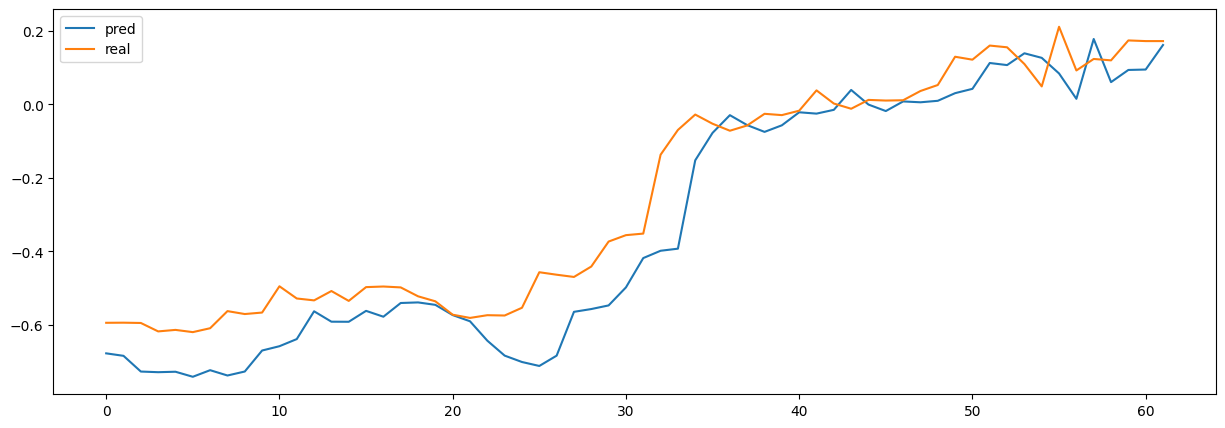

In [14]:
test_df.plot(figsize=(15,5))